In [122]:
import os
import pytorch_lightning as pl
import torch
import yaml
from data_module_norm import EcDataset, NonLinRegDataModule, Normalizer
from model_simple import NonLinearRegression

In [123]:
with open(f"config-jacs.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

normalizer = Normalizer(path=CONFIG["file_path"], normalize_dict=CONFIG["normalize"])
dataset = EcDataset(normalizer=normalizer, roll_out=1)

test_ds = EcDataset(
    start_yr=2022,
    end_yr=2022,
    x_idxs=(500, 500 + 1),
    path="/hpcperm/daep/ecland_i6aj_2017_2022_1h_subset.zarr",
    normalizer=normalizer,
    roll_out=1
)

In [97]:
input_clim_dim = len(dataset.clim_index)  # dataset.x_static_scaled.shape[-1]
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
output_diag_dim = len(dataset.targ_diag_lst)
hidden_dim = CONFIG["hidden_dim"]  # Number of hidden units

std = dataset.normalizer.y_prog_stdevs.cpu().numpy()
ds_mean = dataset.ds_ecland.data_1stdiff_means[dataset.targ_index] / std
ds_std = dataset.ds_ecland.data_1stdiff_stdevs[dataset.targ_index] / std

lower_bound_indices_prog = [dataset.targ_lst.index(x) for x in ["sd"]]
lower_bound_indices_diag = None
upper_bound_indices_prog = [dataset.targ_lst.index(x) for x in ["tsn"]]
upper_bound_indices_diag = None
upper_lower_bound_indices_prog = None
upper_lower_bound_indices_diag = [dataset.targ_diag_lst.index(x) for x in ["snowc_recalc"]]

model_pyt = NonLinearRegression(
    input_clim_dim,
    input_met_dim,
    input_state_dim,
    hidden_dim,
    output_dim,
    output_diag_dim,
    mu_norm=ds_mean,
    std_norm=ds_std,
    dataset=dataset,
    lower_bounded_indices_prog=lower_bound_indices_prog,
    lower_bounded_indices_diag=lower_bound_indices_diag,
    upper_bounded_indices_prog=upper_bound_indices_prog,
    upper_bounded_indices_diag=upper_bound_indices_diag,
    upper_lower_bounded_indices_prog=upper_lower_bound_indices_prog,
    upper_lower_bounded_indices_diag=upper_lower_bound_indices_diag,
)

In [98]:
mod_path = "/home/daep/projects/ai-land/ai_land_minimal/mlruns/791953591827285582/eff42a6625704873a707a02e1bf68892/checkpoints/epoch=71-step=36000.ckpt"
model_pyt.load_state_dict(torch.load(mod_path, map_location=torch.device('cpu'))["state_dict"])

<All keys matched successfully>

In [99]:
test_ds.lons

array([5.183246], dtype=float32)

In [100]:
#clim, met, state, diags = test_ds[200]
clim, met, state, diags = test_ds[2]

In [113]:
clim, met, state, diags = dataset[24*240]

In [114]:
met.shape

torch.Size([1, 164695, 12])

In [115]:
print(test_ds.targ_lst)
print(test_ds.targ_diag_lst)

['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'sd', 'tsn']
['d2m', 't2m', 'skt', 'snowc_recalc']


In [140]:
preds.shape

torch.Size([164695, 8])

In [142]:
def my_model(clim, met, state):
    clim_norm = normalizer.transform(clim, normalizer.clim_means, normalizer.clim_stdevs)
    met_norm = normalizer.transform(met, normalizer.x_dynamic_means, normalizer.x_dynamic_stdevs)
    state_norm = normalizer.transform(state, normalizer.y_prog_means, normalizer.y_prog_stdevs)
    out_norm, out_diag_norm = model_pyt(clim_norm, met_norm, state_norm)
    out = normalizer.inv_transform(out_norm, normalizer.y_prog_means, normalizer.y_prog_stdevs)
    out_diag = normalizer.inv_transform(out_diag_norm, normalizer.y_diag_means, normalizer.y_diag_stdevs)
    return out, out_diag

In [151]:
preds = state[0].clone().detach().requires_grad_(True)
out, out_diag = my_model(
    normalizer.inv_transform(clim[0], normalizer.clim_means, normalizer.clim_stdevs), 
    normalizer.inv_transform(met[0], normalizer.x_dynamic_means, normalizer.x_dynamic_stdevs), 
    normalizer.inv_transform(preds, normalizer.y_prog_means, normalizer.y_prog_stdevs)
                            )

out_diag[:,1].backward(gradient=torch.ones_like(out_diag[:,1]))
gradi_t2 = preds.grad

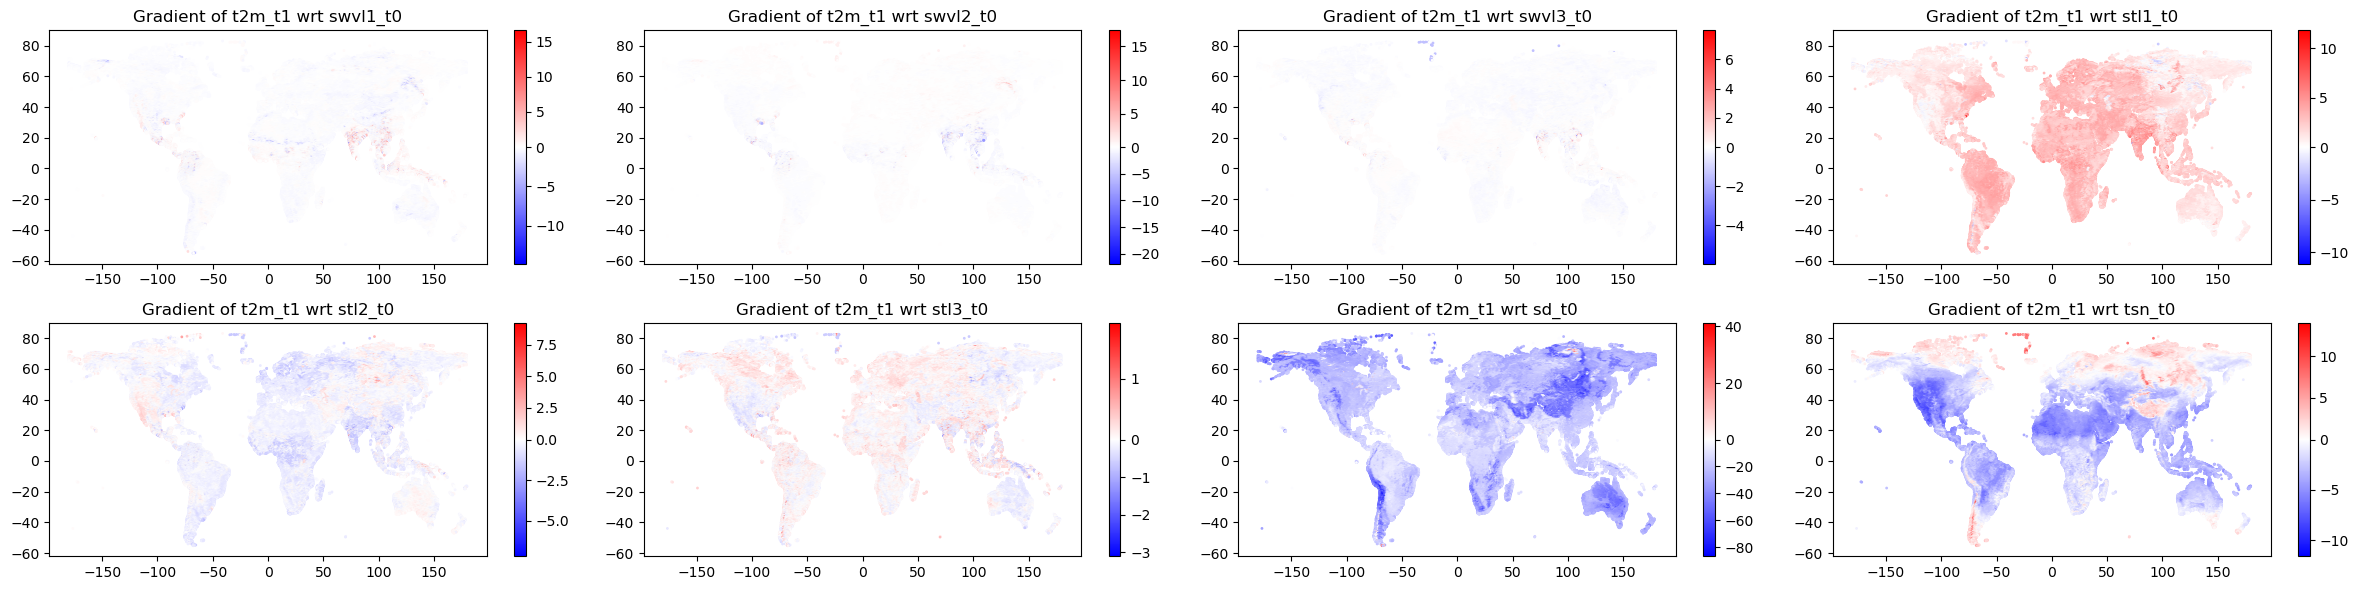

In [157]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24,6))

for i, axes in enumerate(ax.flatten()):
    # c = axes.scatter(dataset.lons, dataset.lats, c=gradi_t2[:,i].numpy(), s=1, cmap="bwr",)  #  vmin=-1, vmax=1)
    c = axes.scatter(dataset.lons, dataset.lats, c=gradi_t2[:,i].numpy(), s=1, cmap="bwr", norm=TwoSlopeNorm(vcenter=0))  #  vmin=-1, vmax=1)
    plt.colorbar(c)
    axes.set_title(f"Gradient of t2m_t1 wrt {dataset.targ_lst[i]}_t0")

fig.tight_layout()

In [141]:
preds = state[0].clone().detach().requires_grad_(True)
out, out_diag = model_pyt(clim[0], met[0], preds)

#out[:,0].backward(gradient=torch.ones_like(out[:,0]))
#gradi_swvl1 = preds.grad

# out_diag[:,1].backward(gradient=torch.ones_like(out_diag[:,1]))
# gradi_t2m = preds.grad

out_diag[:,0].backward(gradient=torch.ones_like(out_diag[:,0]))
gradi_d2m = preds.grad

# out_diag[:,3].backward(gradient=torch.ones_like(out_diag[:,3]))
# gradi_snowc = preds.grad

# out_diag[:,2].backward(gradient=torch.ones_like(out_diag[:,2]))
# gradi_skt = preds.grad

In [130]:
gradi_t2m.shape

torch.Size([164695, 8])

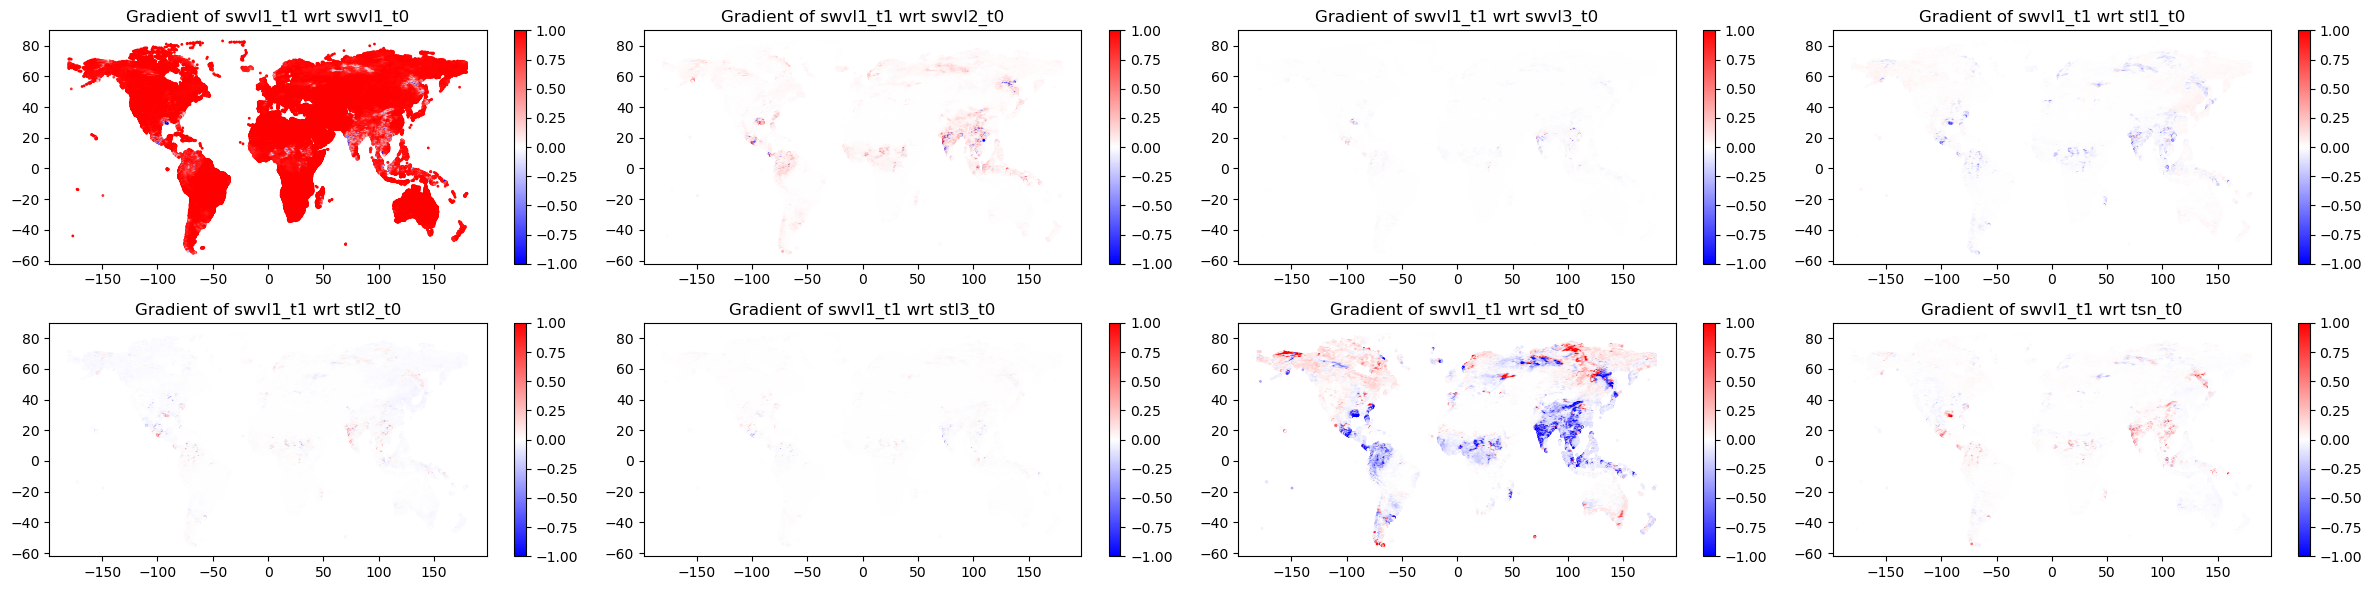

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24,6))

for i, axes in enumerate(ax.flatten()):
    c = axes.scatter(dataset.lons, dataset.lats, c=gradi[:,i].numpy(), s=1, vmin=-1, vmax=1, cmap="bwr")
    plt.colorbar(c)
    axes.set_title(f"Gradient of swvl1_t1 wrt {dataset.targ_lst[i]}_t0")

fig.tight_layout()

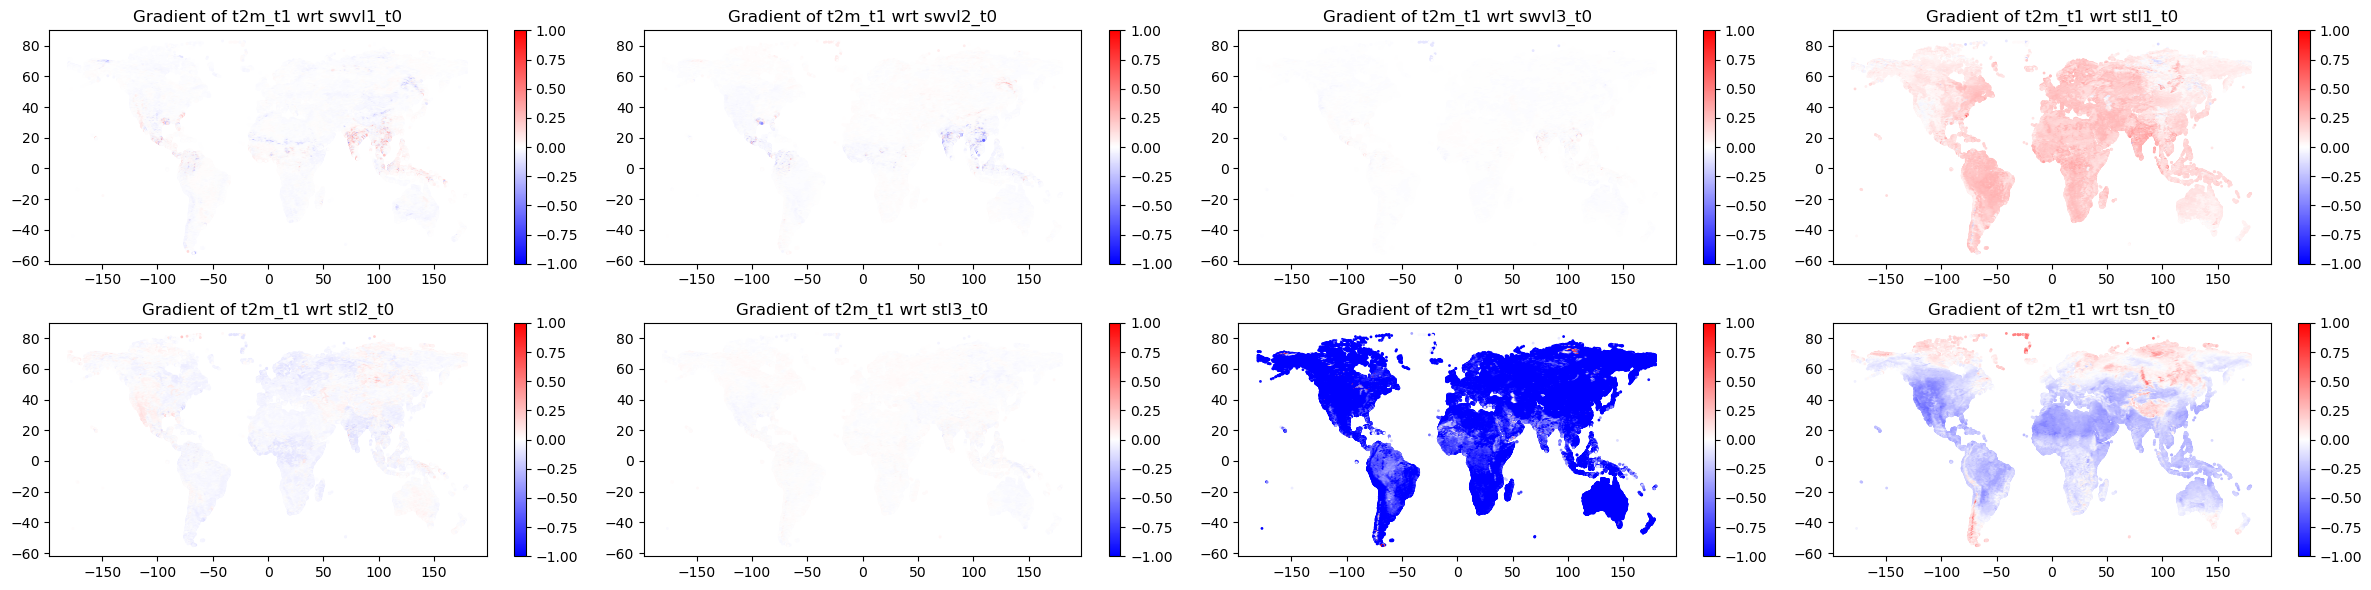

In [131]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24,6))

for i, axes in enumerate(ax.flatten()):
    c = axes.scatter(dataset.lons, dataset.lats, c=gradi_t2m[:,i].numpy(), s=1, vmin=-1, vmax=1, cmap="bwr")
    plt.colorbar(c)
    axes.set_title(f"Gradient of t2m_t1 wrt {dataset.targ_lst[i]}_t0")

fig.tight_layout()

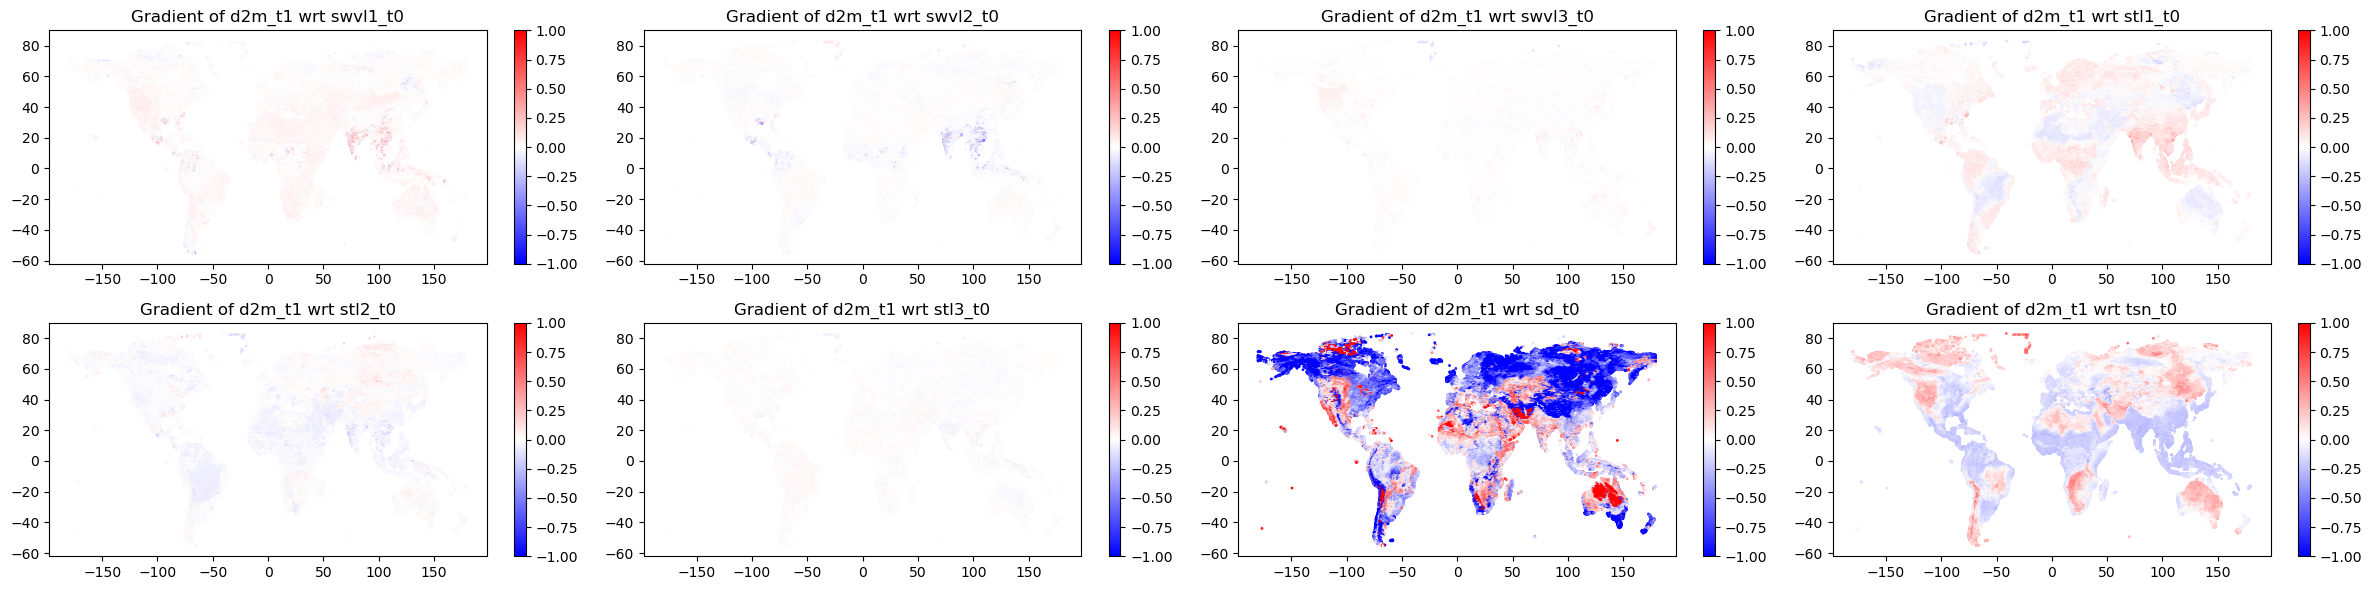

In [139]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24,6))

for i, axes in enumerate(ax.flatten()):
    c = axes.scatter(dataset.lons, dataset.lats, c=gradi_d2m[:,i].numpy(), s=1, vmin=-1, vmax=1, cmap="bwr")
    plt.colorbar(c)
    axes.set_title(f"Gradient of d2m_t1 wrt {dataset.targ_lst[i]}_t0")

fig.tight_layout()

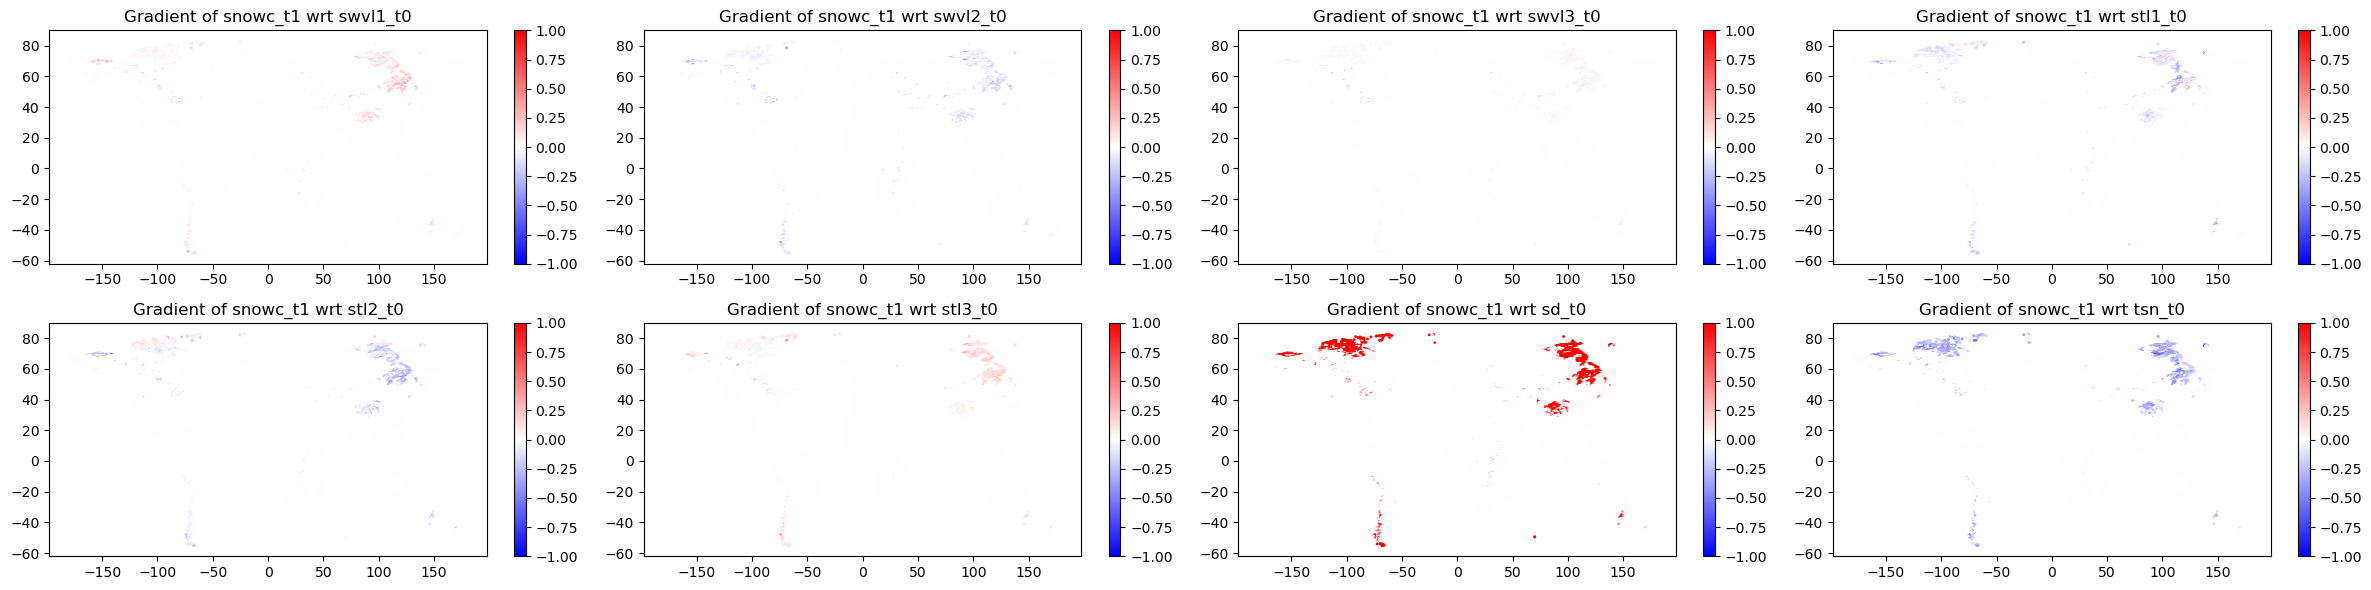

In [133]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24,6))

for i, axes in enumerate(ax.flatten()):
    c = axes.scatter(dataset.lons, dataset.lats, c=gradi_snowc[:,i].numpy(), s=1, vmin=-1, vmax=1, cmap="bwr")
    plt.colorbar(c)
    axes.set_title(f"Gradient of snowc_t1 wrt {dataset.targ_lst[i]}_t0")

fig.tight_layout()

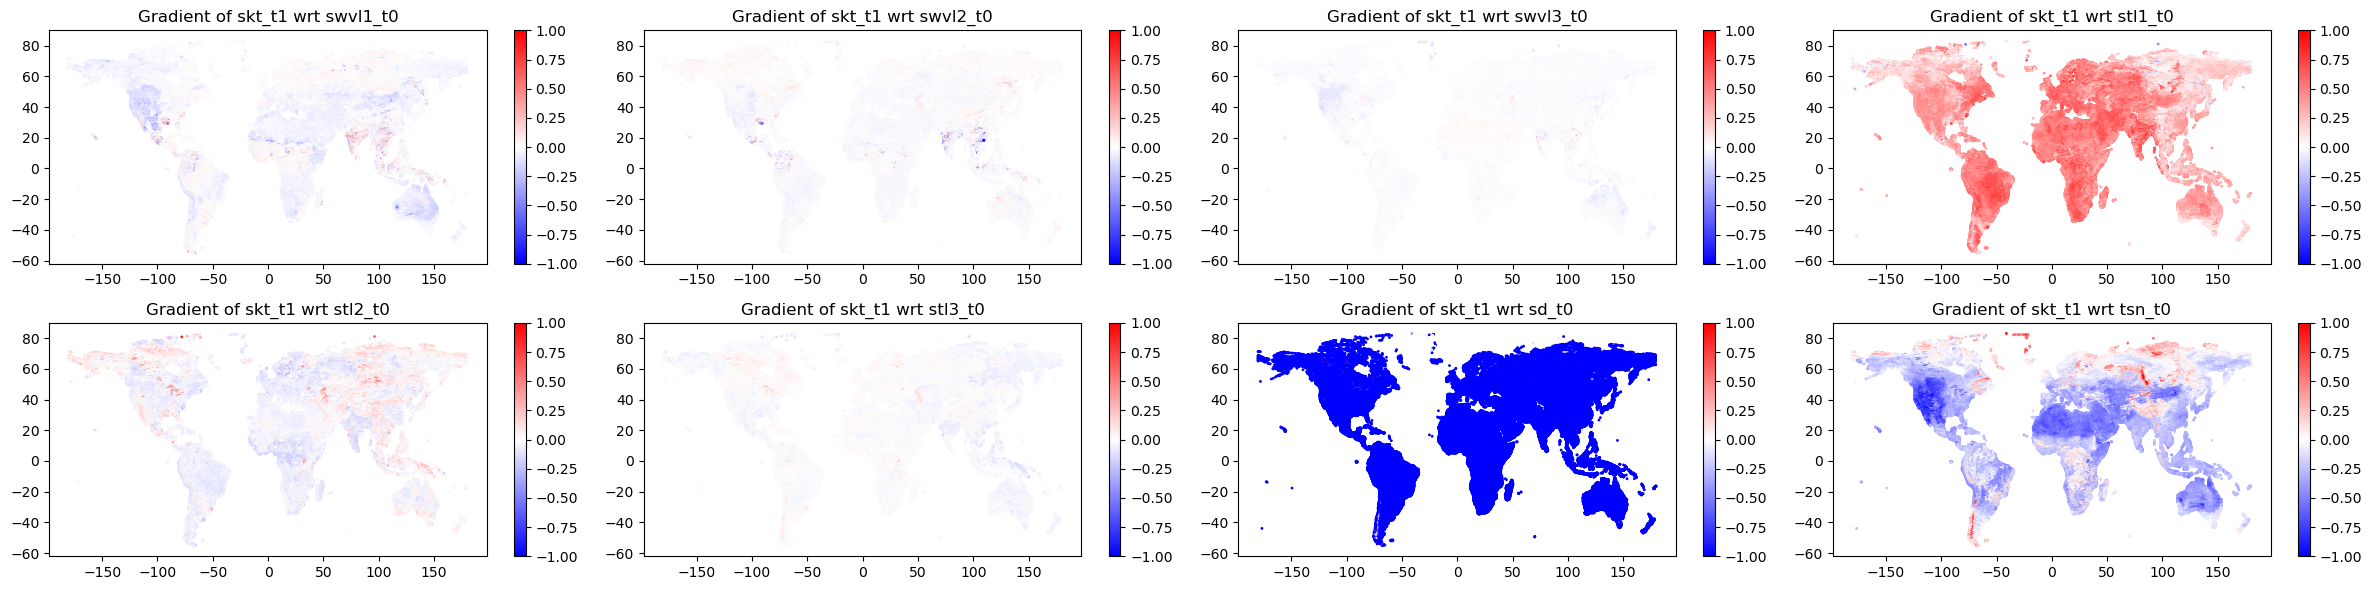

In [137]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24,6))

for i, axes in enumerate(ax.flatten()):
    c = axes.scatter(dataset.lons, dataset.lats, c=gradi_skt[:,i].numpy(), s=1, vmin=-1, vmax=1, cmap="bwr")
    plt.colorbar(c)
    axes.set_title(f"Gradient of skt_t1 wrt {dataset.targ_lst[i]}_t0")

fig.tight_layout()

In [83]:
gradi

tensor([[-1.9923e-02, -2.0513e-03,  7.9454e-03,  1.8262e-01, -8.2258e-03,
         -8.0999e-03, -3.1793e+00,  8.7222e-02]])

In [86]:
gradi

tensor([[-1.9923e-02, -2.0513e-03,  7.9454e-03,  1.8262e-01, -8.2258e-03,
         -8.0999e-03, -3.1793e+00,  8.7222e-02]])